# BalancedRandomForestClassifier

In [1]:
import pandas as pd
train = pd.read_csv('../../../dataset/german_credit_train.csv')
train.head()

,Unnamed: 0,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,507,34,male,3,own,moderate,moderate,6850,15,car,bad
1,249,22,female,2,rent,little,NaN,433,18,radio/TV,bad
2,18,44,female,3,free,little,moderate,12579,24,car,bad
3,436,23,male,1,rent,quite rich,NaN,660,6,repairs,good
4,582,26,female,2,rent,little,NaN,1388,9,furniture/equipment,good


In [2]:
df = train.drop(columns=['Unnamed: 0','risk'])
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose
0,34,male,3,own,moderate,moderate,6850,15,car
1,22,female,2,rent,little,NaN,433,18,radio/TV
2,44,female,3,free,little,moderate,12579,24,car
3,23,male,1,rent,quite rich,NaN,660,6,repairs
4,26,female,2,rent,little,NaN,1388,9,furniture/equipment


In [3]:
y_train = train['risk']

### Transformando dados categóricos em numéricos

In [4]:
cleanup_nums = {"savingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
df.replace(cleanup_nums, inplace=True)

cleanup_nums = {"checkingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
df.replace(cleanup_nums, inplace=True)

d_attr = pd.get_dummies(df[['sex','housing','purpose']], prefix=['sex','housing','purpose'])

In [7]:
print(d_attr.shape)
print(df.shape)

(600, 13)
(600, 9)


In [8]:
df = pd.concat([df, d_attr], axis=1)

In [9]:
df.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,sex_female,...,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,34,male,3,own,2.0,2.0,6850,15,car,0,...,1,0,0,1,0,0,0,0,0,0
1,22,female,2,rent,1.0,NaN,433,18,radio/TV,1,...,0,1,0,0,0,0,0,1,0,0
2,44,female,3,free,1.0,2.0,12579,24,car,1,...,0,0,0,1,0,0,0,0,0,0
3,23,male,1,rent,3.0,NaN,660,6,repairs,0,...,0,1,0,0,0,0,0,0,1,0
4,26,female,2,rent,1.0,NaN,1388,9,furniture/equipment,1,...,0,1,0,0,0,0,1,0,0,0


In [10]:
df.shape

(600, 22)

In [11]:
df.columns

Index(['age', 'sex', 'job', 'housing', 'savingAccount', 'checkingAccount',
       'creditAmount', 'duration', 'purpose', 'sex_female', 'sex_male',
       'housing_free', 'housing_own', 'housing_rent', 'purpose_business',
       'purpose_car', 'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_radio/TV', 'purpose_repairs',
       'purpose_vacation/others'],
      dtype='object')

In [12]:
df = df[['age', 'savingAccount', 'checkingAccount',
       'creditAmount', 'duration', 'sex_female', 'sex_male',
       'housing_free', 'housing_own', 'housing_rent', 'purpose_business',
       'purpose_car', 'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_radio/TV', 'purpose_repairs',
       'purpose_vacation/others']]

In [13]:
df.shape

(600, 18)

### Tratamento dos valores missing - atribuindo o valor mais frequente para os valores missing
savingAccount = 1 e checkingAccount = 1

In [14]:
df = df.fillna(1)
df.head()

,age,savingAccount,checkingAccount,creditAmount,duration,sex_female,sex_male,housing_free,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,34,2.0,2.0,6850,15,0,1,0,1,0,0,1,0,0,0,0,0,0
1,22,1.0,1.0,433,18,1,0,0,0,1,0,0,0,0,0,1,0,0
2,44,1.0,2.0,12579,24,1,0,1,0,0,0,1,0,0,0,0,0,0
3,23,3.0,1.0,660,6,0,1,0,0,1,0,0,0,0,0,0,1,0
4,26,1.0,1.0,1388,9,1,0,0,0,1,0,0,0,0,1,0,0,0


### Escolhendo os melhores hiperparâmetros para o BalancedRandomForestClassifier

In [16]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.ensemble import BalancedRandomForestClassifier 

min_estimators = 100
max_estimators = 4000
step = 100
result = []
for i in range(min_estimators, max_estimators+step, step):
    clf = BalancedRandomForestClassifier(n_estimators=i, max_depth=None, random_state=0)
    s = make_scorer(f1_score, pos_label='bad')
    scores = cross_val_score(clf, df, y_train, cv=5, scoring=s)
    result.append((i, scores.mean()))

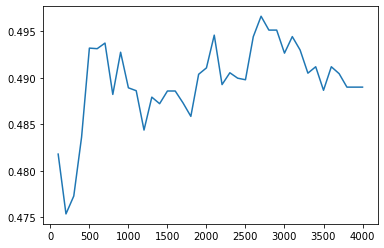

In [17]:
import matplotlib.pyplot as plt
plt.plot(*zip(*result))

In [18]:
max(result,key=lambda item:item[1])

(2700, 0.49659868918271144)

In [20]:
df.head()

,age,savingAccount,checkingAccount,creditAmount,duration,sex_female,sex_male,housing_free,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,34,2.0,2.0,6850,15,0,1,0,1,0,0,1,0,0,0,0,0,0
1,22,1.0,1.0,433,18,1,0,0,0,1,0,0,0,0,0,1,0,0
2,44,1.0,2.0,12579,24,1,0,1,0,0,0,1,0,0,0,0,0,0
3,23,3.0,1.0,660,6,0,1,0,0,1,0,0,0,0,0,0,1,0
4,26,1.0,1.0,1388,9,1,0,0,0,1,0,0,0,0,1,0,0,0


In [17]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.ensemble import BalancedRandomForestClassifier 
clf = BalancedRandomForestClassifier(n_estimators=2700, max_depth=None, random_state=0)
s = make_scorer(f1_score, pos_label='bad')
scores = cross_val_score(clf, df, y_train, cv=5, scoring=s)
y_pred = cross_val_predict(clf, df, y_train, cv=5)
print("f1_score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

f1_score: 0.50 (+/- 0.04)


In [18]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred))
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_train, y_pred))

[[115  59]
 [169 257]]
              precision    recall  f1-score   support

         bad       0.40      0.66      0.50       174
        good       0.81      0.60      0.69       426

    accuracy                           0.62       600
   macro avg       0.61      0.63      0.60       600
weighted avg       0.69      0.62      0.64       600



## Criando o modelo final

In [21]:
clf = BalancedRandomForestClassifier(n_estimators=700, random_state=1234)
clf.fit(df, y_train)
print(clf.feature_importances_)
print(df.columns)

[0.20874363 0.04419133 0.05657115 0.25751529 0.1791116  0.0281949
 0.02806242 0.02161912 0.02975204 0.01805519 0.01765174 0.03127273
 0.00096226 0.01876818 0.01961422 0.03514764 0.00319527 0.00157129]
Index(['age', 'savingAccount', 'checkingAccount', 'creditAmount', 'duration',
       'sex_female', 'sex_male', 'housing_free', 'housing_own', 'housing_rent',
       'purpose_business', 'purpose_car', 'purpose_domestic appliances',
       'purpose_education', 'purpose_furniture/equipment', 'purpose_radio/TV',
       'purpose_repairs', 'purpose_vacation/others'],
      dtype='object')


## Validação final

In [29]:
validacao = pd.read_csv('../../../dataset/german_credit_validation.csv')
validacao = validacao.drop(columns=['Unnamed: 0'])
validacao.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,risk
0,24,male,2,own,little,NaN,1800,18,radio/TV,good
1,33,female,2,own,NaN,NaN,1927,24,education,good
2,30,male,3,free,NaN,NaN,12680,21,car,bad
3,39,female,2,own,little,moderate,1188,21,business,bad
4,44,male,2,free,little,NaN,5507,24,repairs,good


In [30]:
y_validacao = validacao['risk']
validacao = validacao.drop(columns=['risk'])

In [31]:
cleanup_nums = {"savingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
validacao.replace(cleanup_nums, inplace=True)

cleanup_nums = {"checkingAccount": 
                {"little": 1, "moderate": 2, "quite rich": 3, "rich": 4}
               }
validacao.replace(cleanup_nums, inplace=True)

validacao_attr = pd.get_dummies(validacao[['sex','housing','purpose']], prefix=['sex','housing','purpose'])

validacao = pd.concat([validacao, validacao_attr], axis=1)

validacao = validacao.fillna(1)

validacao.head()

,age,sex,job,housing,savingAccount,checkingAccount,creditAmount,duration,purpose,sex_female,...,housing_own,housing_rent,purpose_business,purpose_car,purpose_domestic appliances,purpose_education,purpose_furniture/equipment,purpose_radio/TV,purpose_repairs,purpose_vacation/others
0,24,male,2,own,1.0,1.0,1800,18,radio/TV,0,...,1,0,0,0,0,0,0,1,0,0
1,33,female,2,own,1.0,1.0,1927,24,education,1,...,1,0,0,0,0,1,0,0,0,0
2,30,male,3,free,1.0,1.0,12680,21,car,0,...,0,0,0,1,0,0,0,0,0,0
3,39,female,2,own,1.0,2.0,1188,21,business,1,...,1,0,1,0,0,0,0,0,0,0
4,44,male,2,free,1.0,1.0,5507,24,repairs,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
validacao.columns

Index(['age', 'sex', 'job', 'housing', 'savingAccount', 'checkingAccount',
       'creditAmount', 'duration', 'purpose', 'sex_female', 'sex_male',
       'housing_free', 'housing_own', 'housing_rent', 'purpose_business',
       'purpose_car', 'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_radio/TV', 'purpose_repairs',
       'purpose_vacation/others'],
      dtype='object')

In [33]:
validacao = validacao[['age', 'savingAccount', 'checkingAccount',
       'creditAmount', 'duration', 'sex_female', 'sex_male',
       'housing_free', 'housing_own', 'housing_rent', 'purpose_business',
       'purpose_car', 'purpose_domestic appliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_radio/TV', 'purpose_repairs',
       'purpose_vacation/others']]

In [34]:
pred_validacao = clf.predict(validacao)

In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_validacao, pred_validacao))
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_validacao, pred_validacao))

[[ 78  48]
 [116 158]]
              precision    recall  f1-score   support

         bad       0.40      0.62      0.49       126
        good       0.77      0.58      0.66       274

    accuracy                           0.59       400
   macro avg       0.58      0.60      0.57       400
weighted avg       0.65      0.59      0.60       400

